<a href="https://colab.research.google.com/github/erinmcmahon26/Cervical_Cancer_Risk_Assessment/blob/main/CervicalCancerImages.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

The models in this notebook aren't outputted in the notebook itself. I wrote them to databricks.

In [1]:
!pip install kaggle

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# Upload Kaggle API token

In [2]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))
  
# Then move kaggle.json into the folder where the API expects to find it.
!mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json
User uploaded file "kaggle.json" with length 66 bytes


# Get Data From Kaggle

In [3]:
!kaggle datasets download -d prahladmehandiratta/cervical-cancer-largest-dataset-sipakmed

100% 6.40G/6.40G [01:00<00:00, 144MB/s]
100% 6.40G/6.40G [01:00<00:00, 113MB/s]


# Unzip Kaggle Data

In [4]:
!unzip cervical-cancer-largest-dataset-sipakmed.zip

Streaming output truncated to the last 5000 lines.
  inflating: im_Parabasal/im_Parabasal/CROPPED/075_12_cyt.dat  
  inflating: im_Parabasal/im_Parabasal/CROPPED/075_12_nuc.dat  
  inflating: im_Parabasal/im_Parabasal/CROPPED/075_13.bmp  
  inflating: im_Parabasal/im_Parabasal/CROPPED/075_13_cyt.dat  
  inflating: im_Parabasal/im_Parabasal/CROPPED/075_13_nuc.dat  
  inflating: im_Parabasal/im_Parabasal/CROPPED/075_14.bmp  
  inflating: im_Parabasal/im_Parabasal/CROPPED/075_14_cyt.dat  
  inflating: im_Parabasal/im_Parabasal/CROPPED/075_14_nuc.dat  
  inflating: im_Parabasal/im_Parabasal/CROPPED/076_01.bmp  
  inflating: im_Parabasal/im_Parabasal/CROPPED/076_01_cyt.dat  
  inflating: im_Parabasal/im_Parabasal/CROPPED/076_01_nuc.dat  
  inflating: im_Parabasal/im_Parabasal/CROPPED/076_02.bmp  
  inflating: im_Parabasal/im_Parabasal/CROPPED/076_02_cyt.dat  
  inflating: im_Parabasal/im_Parabasal/CROPPED/076_02_nuc.dat  
  inflating: im_Parabasal/im_Parabasal/CROPPED/076_03.bmp  
  inflati

# Set up MLFlow

https://medium.com/the-point-collections/intro-to-mlflow-with-colab-part-1-2-beb80c960ad9

In [5]:
!pip install mlflow
!databricks configure --host https://community.cloud.databricks.com/

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.7/16.7 MB 47.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.5/79.5 KB 12.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.3/82.3 KB 11.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 KB 6.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 575.9/575.9 KB 47.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 184.3/184.3 KB 23.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 210.5/210.5 KB 26.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 147.5/147.5 KB 18.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 KB 11.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.8/62.8 KB 9.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.9/5

In [6]:
import mlflow
mlflow.set_tracking_uri("databricks")
mlflow.set_experiment("/Users/rachelsickler2024@u.northwestern.edu/cervical_cancer_img")

<Experiment: artifact_location='dbfs:/databricks/mlflow-tracking/1726028455844524', creation_time=1674932314140, experiment_id='1726028455844524', last_update_time=1675547173189, lifecycle_stage='active', name='/Users/rachelsickler2024@u.northwestern.edu/cervical_cancer_img', tags={'mlflow.experiment.sourceName': '/Users/rachelsickler2024@u.northwestern.edu/cervical_cancer_img',
 'mlflow.experimentType': 'MLFLOW_EXPERIMENT',
 'mlflow.ownerEmail': 'rachelsickler2024@u.northwestern.edu',
 'mlflow.ownerId': '382620755183241'}>

In [7]:
import mlflow.tensorflow
mlflow.tensorflow.autolog(every_n_iter=1)

# Other Imports

In [8]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, make_scorer, f1_score
from keras.applications.resnet import ResNet50
from keras.applications.densenet import DenseNet121
from keras.applications.efficientnet import EfficientNetB5
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from keras.models import Sequential
from keras.layers import Dense, Flatten, Dropout
from sklearn.model_selection import train_test_split
import tensorflow
import cv2
import joblib
from sklearn.preprocessing import LabelEncoder
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import os
from keras.applications.efficientnet import EfficientNetB7

In [9]:
def plot_confusion_matrix_labeled(y_true, y_pred, CLASSES_LIST):
    mtx = confusion_matrix(y_true, y_pred)
    # define classes 
    classes = CLASSES_LIST
    temp_df = pd.DataFrame(data=mtx,columns=classes)
    temp_df.index = classes
    fig, ax = plt.subplots(figsize=(5,5))
    sns.heatmap(temp_df, annot=True, fmt='d', linewidths=.75,  cbar=False, ax=ax,cmap='Blues',linecolor='white')
    #  square=True,
    plt.ylabel('true label')
    plt.xlabel('predicted label')
    return plt

In [10]:
CLASS_LIST = ['Dyskeratotic', 'Koilocytotic', 'Metaplastic', 'Parabasal', 'Superficial-Intermediate']

# EDA

In [11]:
# Import modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# from matplotlib.image import imread
# from os import makedirs
# from os import listdir
import os
# from shutil import copyfile
# from random import seed
# from random import random
from PIL import Image
import cv2

import tensorflow as tf
from tensorflow import keras
# import sys
from tensorflow.keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Dropout
from tensorflow.keras.optimizers import SGD
from keras.applications.vgg16 import VGG16
from keras.models import Model
from keras.preprocessing.image import ImageDataGenerator

import warnings
warnings.filterwarnings("ignore")

In [ ]:
data=[]
labels=[]

height = 64
width = 64
channels = 3
classes = 43
n_inputs = height * width * channels

path1 = "im_Dyskeratotic/im_Dyskeratotic/CROPPED/"
path2 = "im_Koilocytotic/im_Koilocytotic/CROPPED/"
path3 = "im_Metaplastic/im_Metaplastic/CROPPED/"
path4 = "im_Parabasal/im_Parabasal/CROPPED/"
path5 = "im_Superficial-Intermediate/im_Superficial-Intermediate/CROPPED/"

path = [path1, path2, path3, path4, path5]

# print(Class)
i = 0
for p in path:
    Class=os.listdir(p)
    for a in Class:
        if(a[-1] == 'p'):
            labels.append(i)
            try:
                image=cv2.imread(p+a)
                image_from_array = Image.fromarray(image, 'RGB')
                size_image = image_from_array.resize((height, width))
                data.append(np.array(size_image))
            except AttributeError:
                print(" ")
    i+=1

# Converting data to ndarray - 
labels = np.array(labels)
data = np.array(data)

print(data.shape)
print(labels.shape)
print(labels)

# Randomize the order of the input images
s = np.arange(data.shape[0])
np.random.seed(43)
np.random.shuffle(s)
data = data[s]
labels = labels[s]


(4049, 64, 64, 3)
(4049,)
[0 0 0 ... 4 4 4]


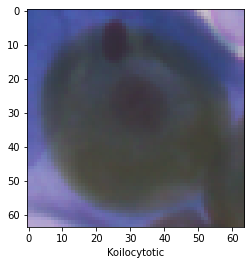

In [ ]:
categories = ["Dyskeratotic", "Koilocytotic", "Metaplastic", "Parabasal", "Superficial-Intermediate"]

def show_the_image(i):
    plt.imshow(data[i])
    plt.xlabel(categories[labels[i]])
    
show_the_image(0)

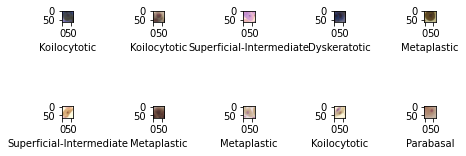

In [ ]:
for i in range(10):
  # plt.subplot(330 + 1 + i) # rows, cols, idx
  plt.subplot(3, 5, i+1) # rows, cols, idx
  plt.imshow(data[i])
  plt.xlabel(categories[labels[i]])
  plt.tight_layout()
  plt.rcParams["figure.figsize"] = (10, 15)

In [ ]:
for p in path:
  print(p, len(os.listdir(p)))

im_Dyskeratotic/im_Dyskeratotic/CROPPED/ 2439
im_Koilocytotic/im_Koilocytotic/CROPPED/ 2475
im_Metaplastic/im_Metaplastic/CROPPED/ 2379
im_Parabasal/im_Parabasal/CROPPED/ 2361
im_Superficial-Intermediate/im_Superficial-Intermediate/CROPPED/ 2493


# Model 1

https://www.kaggle.com/code/sohamgovande/low-res-cervical-cancer-classification

[[  0 825]
 [  1 793]
 [  2 813]
 [  3 787]
 [  4 831]]
127/127 [==============================] - 52s 368ms/step


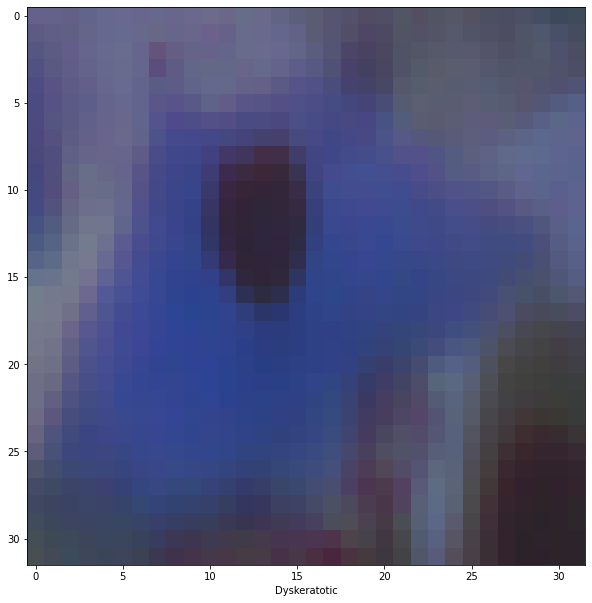

In [ ]:
imgdata = []
labels = []
###### FEEDBACK - how to determine the correct image size?
compressed_img_size = 32

celltypes = ['im_Dyskeratotic', 'im_Koilocytotic', 'im_Metaplastic', 'im_Parabasal', 'im_Superficial-Intermediate']
path = [celltype  + "/" + celltype + "/CROPPED/" for celltype in celltypes]

# Low pass filter
LOW_PASS_FILTER = False
# High pass filter
HIGH_PASS_FILTER = False

cur_label = -1
for celltype in path:
    cur_label += 1
    # Iterate over each cell's individual image
    cellimages = os.listdir(celltype)
    for cellimage in cellimages:
        if cellimage.lower().endswith(".bmp"):
            # Mark each cell with a cell type
            labels.append(cur_label)
            img = cv2.imread(celltype+cellimage)
            img = np.array(Image.fromarray(img, 'RGB').resize((compressed_img_size, compressed_img_size)))
            if LOW_PASS_FILTER:
                img = cv2.GaussianBlur(img, (3, 3), cv2.BORDER_DEFAULT)
            elif HIGH_PASS_FILTER:
                img = img - cv2.GaussianBlur(img, (3, 3), cv2.BORDER_DEFAULT) + 127
            imgdata.append(img)

labels = np.array(labels)
imgdata = np.array(imgdata)

# Shuffle/randomize order
random_order = np.arange(imgdata.shape[0])
np.random.shuffle(random_order)
labels = labels[random_order]
imgdata = imgdata[random_order]

# Get # of each cell type
unique, counts = np.unique(labels, return_counts=True)
print(np.asarray((unique, counts)).T)

# Used for generating figures (displaying cell images)
def disp_img(i):
    plt.imshow(imgdata[i])
    plt.xlabel(celltypes[labels[i]][len('im_'):])
    
for i in range(0, len(labels)):
    # Replace this with 0, 1, 2, 3, or 4 depending on the type of figure being generated
    if labels[i] == 2:
        disp_img(i)
        break

# Initialize neural networks
# do not include the fully-connected layer at the top of the network
model_efficientnet = EfficientNetB7(weights=None, include_top = False)
features_efficientnet = model_efficientnet.predict(imgdata, batch_size=32)

cur = features_efficientnet
extracted_features = []
zipped_data = zip(cur, labels)
for cur, label in zipped_data:
    cur = np.append(cur.reshape(cur.shape[0] * cur.shape[1] * cur.shape[2]), label)
    extracted_features.append(cur)
extracted_features = np.array(extracted_features)

# Use min-max scaling to normalize the data
X = extracted_features[:, 0:-1]
y = extracted_features[:, -1]
scaler = MinMaxScaler()
scaled_X = scaler.fit_transform(X)

# PCA
pca = PCA(n_components = 0.95) # represent 95% of the variation through principal components
pca.fit(scaled_X)
pca_x = pca.transform(scaled_X)

X_train, X_test, y_train, y_test = train_test_split(pca_x, y, test_size = 0.2, random_state = 49)

# Neural network for classification
model = Sequential([
    Flatten(input_shape=(X_train.shape[1], 1)),
    Dense(256, activation='relu'),
    Dropout(rate=0.8),
    Dense(5, activation='softmax')
])

model.compile(loss='sparse_categorical_crossentropy',  optimizer='adam', metrics=['accuracy'])

In [ ]:
# Train the neural network
nn = model.fit(X_train, y_train, batch_size=32, epochs=50)

Epoch 1/50
102/102 [==============================] - 1s 2ms/step - loss: 1.4550 - accuracy: 0.4310
Epoch 2/50
102/102 [==============================] - 0s 2ms/step - loss: 1.0845 - accuracy: 0.5823
Epoch 3/50
102/102 [==============================] - 0s 2ms/step - loss: 0.9518 - accuracy: 0.6422
Epoch 4/50
102/102 [==============================] - 0s 2ms/step - loss: 0.8736 - accuracy: 0.6761
Epoch 5/50
102/102 [==============================] - 0s 2ms/step - loss: 0.8451 - accuracy: 0.6934
Epoch 6/50
102/102 [==============================] - 0s 2ms/step - loss: 0.8000 - accuracy: 0.7110
Epoch 7/50
102/102 [==============================] - 0s 2ms/step - loss: 0.7848 - accuracy: 0.7095
Epoch 8/50
102/102 [==============================] - 0s 2ms/step - loss: 0.7450 - accuracy: 0.7339
Epoch 9/50
102/102 [==============================] - 0s 2ms/step - loss: 0.7359 - accuracy: 0.7320
Epoch 10/50
102/102 [==============================] - 0s 2ms/step - loss: 0.7284 - accuracy: 0.7357

In [ ]:
# Predict on the test set and determine the accuracy
y_pred = np.argmax(model.predict(X_test), axis=1)
print("Accuracy is: " + str(accuracy_score(y_test, y_pred)*100) + '%')

26/26 [==============================] - 0s 2ms/step
Accuracy is: 83.08641975308642%


In [ ]:
history_dict = nn.history
history_dict.keys()

dict_keys(['loss', 'accuracy'])

In [ ]:
history_df=pd.DataFrame(history_dict)
history_df.tail().round(3)

,loss,accuracy
45,0.516,0.810
46,0.496,0.816
47,0.520,0.810
48,0.505,0.808
49,0.509,0.806


In [ ]:
# compute and print classification report
print(classification_report(y_test, y_pred, target_names=CLASS_LIST))

                          precision    recall  f1-score   support

            Koilocytotic       0.86      0.71      0.78       163
             Metaplastic       0.87      0.87      0.87       166
            Dyskeratotic       0.85      0.96      0.90       145
               Parabasal       0.88      0.92      0.90       168
Superficial-Intermediate       0.80      0.81      0.80       168

                accuracy                           0.85       810
               macro avg       0.85      0.85      0.85       810
            weighted avg       0.85      0.85      0.85       810



In [ ]:
report = classification_report(y_test, y_pred, target_names=CLASS_LIST, output_dict=True)

In [ ]:
report

{'Koilocytotic': {'precision': 0.8592592592592593,
  'recall': 0.7116564417177914,
  'f1-score': 0.7785234899328859,
  'support': 163},
 'Metaplastic': {'precision': 0.8682634730538922,
  'recall': 0.8734939759036144,
  'f1-score': 0.8708708708708709,
  'support': 166},
 'Dyskeratotic': {'precision': 0.852760736196319,
  'recall': 0.9586206896551724,
  'f1-score': 0.9025974025974026,
  'support': 145},
 'Parabasal': {'precision': 0.88,
  'recall': 0.9166666666666666,
  'f1-score': 0.8979591836734694,
  'support': 168},
 'Superficial-Intermediate': {'precision': 0.8,
  'recall': 0.8095238095238095,
  'f1-score': 0.8047337278106509,
  'support': 168},
 'accuracy': 0.8518518518518519,
 'macro avg': {'precision': 0.8520566937018941,
  'recall': 0.8539923166934109,
  'f1-score': 0.8509369349770559,
  'support': 810},
 'weighted avg': {'precision': 0.8519522253514464,
  'recall': 0.8518518518518519,
  'f1-score': 0.8498678097896056,
  'support': 810}}

In [ ]:
report['accuracy']

0.8395061728395061

In [ ]:
c = confusion_matrix(y_test, y_pred)
c

array([[116,   9,  15,   5,  18],
       [  7, 145,   0,   6,   8],
       [  5,   0, 139,   0,   1],
       [  0,   2,   5, 154,   7],
       [  7,  11,   4,  10, 136]])

In [ ]:
c[1][1]

145

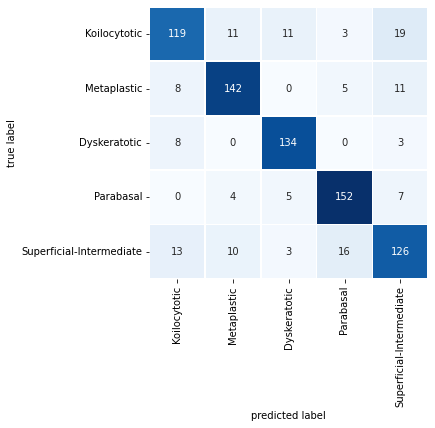

In [ ]:
plot = plot_confusion_matrix_labeled(y_test, y_pred, CLASSES_LIST=CLASS_LIST)
plot.savefig("confusionMatrix.png")
plot.show()
plot.close()

mlflow.log_artifact("confusionMatrix.png")

In [ ]:
joblib.dump(model, 'model1.pkl')

['model1.pkl']

## MLFlow

In [ ]:
# write to an existing experiment
experiment = mlflow.get_experiment_by_name('/Users/rachelsickler2024@u.northwestern.edu/cervical_cancer_img')
experiment_id = experiment.experiment_id
run_name = 'model1'
description = 'efficientnetb7, cnn'

In [ ]:
with mlflow.start_run(
        experiment_id=experiment_id,
        run_name=run_name,
        description=description,
) as run:

  # Low pass filter
  LOW_PASS_FILTER = False
  # High pass filter
  HIGH_PASS_FILTER = False

  # Initialize neural networks
  # do not include the fully-connected layer at the top of the network
  model_efficientnet = EfficientNetB7(weights=None, include_top = False)
  features_efficientnet = model_efficientnet.predict(imgdata, batch_size=32)

  cur = features_efficientnet
  extracted_features = []
  zipped_data = zip(cur, labels)
  for cur, label in zipped_data:
      cur = np.append(cur.reshape(cur.shape[0] * cur.shape[1] * cur.shape[2]), label)
      extracted_features.append(cur)
  extracted_features = np.array(extracted_features)

  # Use min-max scaling to normalize the data
  X = extracted_features[:, 0:-1]
  y = extracted_features[:, -1]
  scaler = MinMaxScaler()
  scaled_X = scaler.fit_transform(X)

  # PCA
  pca = PCA(n_components = 0.95) # represent 95% of the variation through principal components
  pca.fit(scaled_X)
  pca_x = pca.transform(scaled_X)

  X_train, X_test, y_train, y_test = train_test_split(pca_x, y, test_size = 0.2, random_state = 49)

  # Neural network for classification
  model = Sequential([
      Flatten(input_shape=(X_train.shape[1], 1)),
      Dense(256, activation='relu'),
      Dropout(rate=0.8),
      Dense(5, activation='softmax')
  ])

  model.compile(loss='sparse_categorical_crossentropy',  optimizer='adam', metrics=['accuracy'])

  # Train the neural network
  nn = model.fit(X_train, y_train, batch_size=32, epochs=50)

  # Predict on the test set and determine the accuracy
  y_pred = np.argmax(model.predict(X_test), axis=1)
  print("Accuracy is: " + str(accuracy_score(y_test, y_pred)*100) + '%')

  # compute and print classification report
  confusion = confusion_matrix(y_test, y_pred)

  # compute and print classification report
  # print(classification_report(y_test, y_pred))
  plot = plot_confusion_matrix_labeled(y_test, y_pred, CLASSES_LIST=CLASS_LIST)
  plot.savefig("confusionMatrix.png")
  # plot.show()
  plot.close()
  mlflow.log_artifact("confusionMatrix.png")

  report = classification_report(y_test, y_pred, target_names=CLASS_LIST, output_dict=True)

  metrics = {}
  metrics['Koilocytotic_precision'] = report['Koilocytotic']['precision']
  metrics['Koilocytotic_recall'] = report['Koilocytotic']['recall']
  metrics['Koilocytotic_f1'] = report['Koilocytotic']['f1-score']
  metrics['Koilocytotic_support'] = report['Koilocytotic']['support']
  metrics['Metaplastic_precision'] = report['Metaplastic']['precision']
  metrics['Metaplastic_recall'] = report['Metaplastic']['recall']
  metrics['Metaplastic_f1'] = report['Metaplastic']['f1-score']
  metrics['Metaplastic_support'] = report['Metaplastic']['support']
  metrics['Dyskeratotic_precision'] = report['Dyskeratotic']['precision']
  metrics['Dyskeratotic_recall'] = report['Dyskeratotic']['recall']
  metrics['Dyskeratotic_f1'] = report['Dyskeratotic']['f1-score']
  metrics['Dyskeratotic_support'] = report['Dyskeratotic']['support']
  metrics['Parabasal_precision'] = report['Parabasal']['precision']
  metrics['Parabasal_recall'] = report['Parabasal']['recall']
  metrics['Parabasal_f1'] = report['Parabasal']['f1-score']
  metrics['Parabasal_support'] = report['Parabasal']['support']
  metrics['SI_precision'] = report['Superficial-Intermediate']['precision']
  metrics['SI_recall'] = report['Superficial-Intermediate']['recall']
  metrics['SI_f1'] = report['Superficial-Intermediate']['f1-score']
  metrics['SI_support'] = report['Superficial-Intermediate']['support']
  metrics['accuracy'] = report['accuracy']
  metrics['tp_Koilocytotic'] = confusion[0][0]
  metrics['tp_Metaplastic'] = confusion[1][1]
  metrics['tp_Dyskeratotic'] = confusion[2][2]
  metrics['tp_Parabasal'] = confusion[3][3]
  metrics['tp_SI'] = confusion[4][4]
  metrics['f1_score'] = f1_score(y_test, y_pred, average='weighted')
  metrics['low_pass_filer'] = LOW_PASS_FILTER
  metrics['high_pass_filter'] = HIGH_PASS_FILTER

  mlflow.log_metrics(metrics)

  joblib.dump(model, 'model1.pkl')
  mlflow.log_artifact('model1.pkl')

127/127 [==============================] - 54s 373ms/step
Epoch 1/50
102/102 [==============================] - 1s 4ms/step - loss: 1.5256 - accuracy: 0.4159
Epoch 2/50
102/102 [==============================] - 0s 2ms/step - loss: 1.0873 - accuracy: 0.5783
Epoch 3/50
102/102 [==============================] - 0s 2ms/step - loss: 0.9577 - accuracy: 0.6406
Epoch 4/50
102/102 [==============================] - 0s 2ms/step - loss: 0.8837 - accuracy: 0.6761
Epoch 5/50
102/102 [==============================] - 0s 2ms/step - loss: 0.8335 - accuracy: 0.6974
Epoch 6/50
102/102 [==============================] - 0s 2ms/step - loss: 0.7962 - accuracy: 0.7061
Epoch 7/50
102/102 [==============================] - 0s 4ms/step - loss: 0.7768 - accuracy: 0.7228
Epoch 8/50
102/102 [==============================] - 0s 2ms/step - loss: 0.7353 - accuracy: 0.7311
Epoch 9/50
102/102 [==============================] - 0s 2ms/step - loss: 0.7166 - accuracy: 0.7410
Epoch 10/50
102/102 [=====================

2023/01/28 21:48:52 WARNING mlflow.utils.requirements_utils: Found jaxlib version (0.3.25+cuda11.cudnn805) contains a local version label (+cuda11.cudnn805). MLflow logged a pip requirement for this package as 'jaxlib==0.3.25' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.


26/26 [==============================] - 0s 2ms/step
Accuracy is: 83.08641975308642%


# Model 2

https://www.kaggle.com/code/kanishk26/sipkamed-dataset

In [78]:
data=[]
labels=[]

height = 64
width = 64
channels = 3
classes = 43
n_inputs = height * width * channels

path1 = "im_Dyskeratotic/im_Dyskeratotic/CROPPED/"
path2 = "im_Koilocytotic/im_Koilocytotic/CROPPED/"
path3 = "im_Metaplastic/im_Metaplastic/CROPPED/"
path4 = "im_Parabasal/im_Parabasal/CROPPED/"
path5 = "im_Superficial-Intermediate/im_Superficial-Intermediate/CROPPED/"

path = [path1, path2, path3, path4, path5]

# print(Class)
i = 0
for p in path:
    Class=os.listdir(p)
    for a in Class:
        if(a[-1] == 'p'):
            labels.append(i)
            try:
                image=cv2.imread(p+a)
                image_from_array = Image.fromarray(image, 'RGB')
                size_image = image_from_array.resize((height, width))
                data.append(np.array(size_image))
            except AttributeError:
                print(" ")
    i+=1

# Converting data to ndarray - 
labels = np.array(labels)
data = np.array(data)

print(data.shape)
print(labels.shape)
print(labels)

# Randomize the order of the input images
s = np.arange(data.shape[0])
np.random.seed(43)
np.random.shuffle(s)
data = data[s]
labels = labels[s]

(4049, 64, 64, 3)
(4049,)
[0 0 0 ... 4 4 4]


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
127/127 [==============================] - 65s 505ms/step


2023/02/20 01:05:17 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '140a16fdce7347eba6e44d1ee44ae709', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current tensorflow workflow


Epoch 1/15


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
102/102 [==============================] - 2s 9ms/step - loss: 0.9275 - accuracy: 0.7366
Epoch 2/15
102/102 [==============================] - 1s 7ms/step - loss: 0.2484 - accuracy: 0.9506
Epoch 3/15
102/102 [==============================] - 1s 9ms/step - loss: 0.1107 - accuracy: 0.9812
Epoch 4/15
102/102 [==============================] - 1s 8ms/step - loss: 0.0577 - accuracy: 0.9944
Epoch 5/15
102/102 [==============================] - 1s 9ms/step - loss: 0.0364 - accuracy: 0.9963
Epoch 6/15
102/102 [==============================] - 1s 9ms/step - loss: 0.0247 - accuracy: 0.9988
Epoch 7/15
102/102 [==============================] - 1s 8ms/step - 

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
1/1 [==============================] - 0s 73ms/step


Cause: Unable to locate the source code of <function trace_model_call.<locals>._wrapped_model at 0x7ff04d7d4040>. Note that functions defined in certain environments, like the interactive Python shell, do not expose their source code. If that is the case, you should define them in a .py source file. If you are certain the code is graph-compatible, wrap the call using @tf.autograph.experimental.do_not_convert. Original error: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: Unable to locate the source code of <function trace_model_call.<locals>._wrapped_model at 0x7ff04d7d4040>. Note that functions defined in certain environments, like the interactive Python shell, do not expose their source code. If that is the case, you should define them in a .py source file. If you are certain the code is graph-compatible, wrap the call using @tf.autograph.experimental.do_not_convert. Original error: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


2023/02/20 01:05:53 WARNING mlflow.utils.environment: Encountered an unexpected error while inferring pip requirements (model URI: /tmp/tmpvc0wqsqe/model, flavor: tensorflow), fall back to return ['tensorflow==2.9.2']. Set logging level to DEBUG to see the full traceback.


26/26 [==============================] - 0s 3ms/step
Accuracy is: 90.8641975308642%


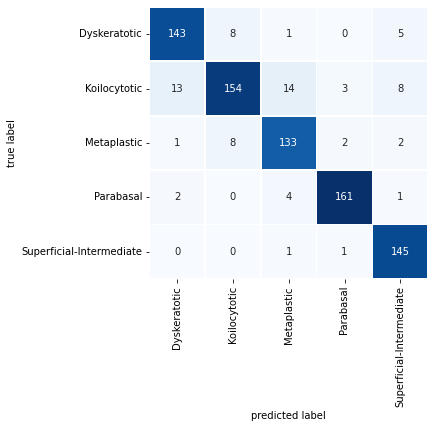

{'Dyskeratotic': {'precision': 0.89937106918239, 'recall': 0.910828025477707, 'f1-score': 0.9050632911392406, 'support': 157}, 'Koilocytotic': {'precision': 0.9058823529411765, 'recall': 0.8020833333333334, 'f1-score': 0.850828729281768, 'support': 192}, 'Metaplastic': {'precision': 0.869281045751634, 'recall': 0.910958904109589, 'f1-score': 0.8896321070234113, 'support': 146}, 'Parabasal': {'precision': 0.9640718562874252, 'recall': 0.9583333333333334, 'f1-score': 0.9611940298507463, 'support': 168}, 'Superficial-Intermediate': {'precision': 0.9006211180124224, 'recall': 0.9863945578231292, 'f1-score': 0.9415584415584415, 'support': 147}, 'accuracy': 0.908641975308642, 'macro avg': {'precision': 0.9078454884350096, 'recall': 0.9137196308154184, 'f1-score': 0.9096553197707216, 'support': 810}, 'weighted avg': {'precision': 0.9091371339632015, 'recall': 0.908641975308642, 'f1-score': 0.9076913929387587, 'support': 810}}


In [98]:
model_resnet       = ResNet50(weights = 'imagenet', include_top = False)
# model_densenet     = DenseNet121(weights = 'imagenet', include_top = False)
# model_efficientnet = EfficientNetB5(weights = 'imagenet', include_top = False)

features_resnet       = model_resnet.predict(data, batch_size=32)
# features_densenet     = model_densenet.predict(data, batch_size=32)
# features_efficientnet = model_densenet.predict(data, batch_size=32)

extracted_features = []
# for f_r, f_d, f_e, label in zip(features_resnet, features_densenet, features_efficientnet, labels):
for f_r,  label in zip(features_resnet, labels):
  f_r = f_r.reshape(f_r.shape[0] * f_r.shape[1] * f_r.shape[2])
  # f_d = f_d.reshape(f_d.shape[0] * f_d.shape[1] * f_d.shape[2])
  # f_e = f_e.reshape(f_e.shape[0] * f_e.shape[1] * f_e.shape[2])
  
  # f_r = np.append(f_r, f_d)
  # f_r = np.append(f_r, f_e)
  f_r = np.append(f_r, label)
  extracted_features.append(f_r)

extracted_features = np.array(extracted_features)

# Normalization
X = extracted_features[:, 0:-1]
y = extracted_features[:, -1]

scaler = MinMaxScaler()
scaled_X = scaler.fit_transform(X)
    
extracted_features = np.array(extracted_features)

# PCA
pca = PCA(n_components = 0.95)
pca.fit(scaled_X)
principal_X = pca.transform(scaled_X)

X_train, X_test, y_train, y_test = train_test_split(principal_X, y, test_size = 0.2, random_state = 6140)

model = Sequential()

# model.add(Flatten(input_shape=(X_train.shape[1], 1)))
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(rate=0.5))
model.add(Dense(5, activation='softmax'))

#Compilation of the model
model.compile(
    loss='sparse_categorical_crossentropy', 
    optimizer='adam', 
    metrics=['accuracy']
)

epochs = 15

# Train the neural network
nn = model.fit(X_train, y_train, batch_size=32, epochs=epochs)

# Predict on the test set and determine the accuracy
y_pred = np.argmax(model.predict(X_test), axis=1)
print("Accuracy is: " + str(accuracy_score(y_test, y_pred)*100) + '%')

#########################################
# compute and print classification report
confusion = confusion_matrix(y_test, y_pred)

# compute and print classification report
# print(classification_report(y_test, y_pred))
plot = plot_confusion_matrix_labeled(y_test, y_pred, CLASSES_LIST=CLASS_LIST)
# plot.savefig("confusionMatrix.png", bbox_inches="tight")
plot.show()
plot.close()
# mlflow.log_artifact("confusionMatrix.png")

report = classification_report(y_test, y_pred, target_names=CLASS_LIST, output_dict=True)
print(report)

In [81]:
# save the file
import joblib
# save the model in Google drive
joblib.dump(model, 'img_model.pkl')

Keras weights file (<HDF5 file "variables.h5" (mode r+)>) saving:
...layers
......dense
.........vars
............0
............1
......dense_1
.........vars
............0
............1
......dropout
.........vars
......flatten
.........vars
...metrics
......mean
.........vars
............0
............1
......mean_metric_wrapper
.........vars
............0
............1
...optimizer
......vars
.........0
.........1
.........2
.........3
.........4
.........5
.........6
.........7
.........8
...vars
Keras model archive saving:
File Name                                             Modified             Size
variables.h5                                   2023-02-20 00:29:13      5089712
config.json                                    2023-02-20 00:29:12         1704
metadata.json                                  2023-02-20 00:29:12           64


['img_model.pkl']

In [ ]:
mlflow.end_run()

In [ ]:
# write to an existing experiment
experiment = mlflow.get_experiment_by_name('/Users/rachelsickler2024@u.northwestern.edu/cervical_cancer_img')
experiment_id = experiment.experiment_id
run_name = 'model2'
description = 'ResNet50, cnn - corrected confusion matrix'

Transfer learning means taking a pre-trained machine learning model and repurposing it for another related task for faster development. It helps achieve higher performance even if the model is trained on a smaller dataset.

In short, the residual blocks make it considerably easier for the layers to learn identity functions. As a result, ResNet improves the efficiency of deep neural networks with more neural layers while minimizing the percentage of errors. In other words, the skip connections add the outputs from previous layers to the outputs of stacked layers, making it possible to train much deeper networks than previously possible.
Read more at: https://viso.ai/deep-learning/resnet-residual-neural-network/

In [ ]:
with mlflow.start_run(
        experiment_id=experiment_id,
        run_name=run_name,
        description=description,
) as run:
  # Loading ResNet50 with imagenet weights, include_top means that we're loading model without last fully connected layers
  model_resnet       = ResNet50(weights = 'imagenet', include_top = False)

  features_resnet       = model_resnet.predict(data, batch_size=32)

  extracted_features = []
  for f_r,  label in zip(features_resnet, labels):
    f_r = f_r.reshape(f_r.shape[0] * f_r.shape[1] * f_r.shape[2])
    f_r = np.append(f_r, label)
    extracted_features.append(f_r)

  extracted_features = np.array(extracted_features)

  # Normalization
  X = extracted_features[:, 0:-1]
  y = extracted_features[:, -1]

  scaler = MinMaxScaler()
  scaled_X = scaler.fit_transform(X)
      
  extracted_features = np.array(extracted_features)

  # PCA
  pca = PCA(n_components = 0.95)
  pca.fit(scaled_X)
  principal_X = pca.transform(scaled_X)

  X_train, X_test, y_train, y_test = train_test_split(principal_X, y, test_size = 0.2, random_state = 6140)

  model = Sequential()

  model.add(Flatten(input_shape=(X_train.shape[1], 1)))
  model.add(Dense(256, activation='relu'))
  model.add(Dropout(rate=0.5))
  model.add(Dense(5, activation='softmax'))

  #Compilation of the model
  model.compile(
      loss='sparse_categorical_crossentropy', 
      optimizer='adam', 
      metrics=['accuracy']
  )

  epochs = 15

  # Train the neural network
  nn = model.fit(X_train, y_train, batch_size=32, epochs=epochs)

  # Predict on the test set and determine the accuracy
  y_pred = np.argmax(model.predict(X_test), axis=1)
  print("Accuracy is: " + str(accuracy_score(y_test, y_pred)*100) + '%')

  #########################################
  # compute and print classification report
  confusion = confusion_matrix(y_test, y_pred)

  # compute and print classification report
  # print(classification_report(y_test, y_pred))
  plot = plot_confusion_matrix_labeled(y_test, y_pred, CLASSES_LIST=CLASS_LIST)
  plot.savefig("confusionMatrix.png", bbox_inches="tight")
  # plot.show()
  plot.close()
  mlflow.log_artifact("confusionMatrix.png")

  report = classification_report(y_test, y_pred, target_names=CLASS_LIST, output_dict=True)

  metrics = {}
  metrics['Koilocytotic_precision'] = report['Koilocytotic']['precision']
  metrics['Koilocytotic_recall'] = report['Koilocytotic']['recall']
  metrics['Koilocytotic_f1'] = report['Koilocytotic']['f1-score']
  metrics['Koilocytotic_support'] = report['Koilocytotic']['support']
  metrics['Metaplastic_precision'] = report['Metaplastic']['precision']
  metrics['Metaplastic_recall'] = report['Metaplastic']['recall']
  metrics['Metaplastic_f1'] = report['Metaplastic']['f1-score']
  metrics['Metaplastic_support'] = report['Metaplastic']['support']
  metrics['Dyskeratotic_precision'] = report['Dyskeratotic']['precision']
  metrics['Dyskeratotic_recall'] = report['Dyskeratotic']['recall']
  metrics['Dyskeratotic_f1'] = report['Dyskeratotic']['f1-score']
  metrics['Dyskeratotic_support'] = report['Dyskeratotic']['support']
  metrics['Parabasal_precision'] = report['Parabasal']['precision']
  metrics['Parabasal_recall'] = report['Parabasal']['recall']
  metrics['Parabasal_f1'] = report['Parabasal']['f1-score']
  metrics['Parabasal_support'] = report['Parabasal']['support']
  metrics['SI_precision'] = report['Superficial-Intermediate']['precision']
  metrics['SI_recall'] = report['Superficial-Intermediate']['recall']
  metrics['SI_f1'] = report['Superficial-Intermediate']['f1-score']
  metrics['SI_support'] = report['Superficial-Intermediate']['support']
  metrics['accuracy'] = report['accuracy']
  metrics['tp_Koilocytotic'] = confusion[0][0]
  metrics['tp_Metaplastic'] = confusion[1][1]
  metrics['tp_Dyskeratotic'] = confusion[2][2]
  metrics['tp_Parabasal'] = confusion[3][3]
  metrics['tp_SI'] = confusion[4][4]
  metrics['f1_score'] = f1_score(y_test, y_pred, average='weighted')

  mlflow.log_metrics(metrics)

  joblib.dump(model, 'model2.pkl')
  mlflow.log_artifact('model2.pkl')

127/127 [==============================] - 54s 407ms/step
Epoch 1/15
102/102 [==============================] - 1s 7ms/step - loss: 0.9039 - accuracy: 0.7601
Epoch 2/15
102/102 [==============================] - 1s 5ms/step - loss: 0.2415 - accuracy: 0.9515
Epoch 3/15
102/102 [==============================] - 1s 6ms/step - loss: 0.1049 - accuracy: 0.9821
Epoch 4/15
102/102 [==============================] - 1s 5ms/step - loss: 0.0584 - accuracy: 0.9926
Epoch 5/15
102/102 [==============================] - 1s 6ms/step - loss: 0.0376 - accuracy: 0.9957
Epoch 6/15
102/102 [==============================] - 1s 5ms/step - loss: 0.0247 - accuracy: 0.9978
Epoch 7/15
102/102 [==============================] - 1s 6ms/step - loss: 0.0169 - accuracy: 0.9994
Epoch 8/15
102/102 [==============================] - 1s 5ms/step - loss: 0.0126 - accuracy: 0.9997
Epoch 9/15
102/102 [==============================] - 1s 6ms/step - loss: 0.0103 - accuracy: 1.0000
Epoch 10/15
102/102 [=====================

2023/01/29 16:01:28 WARNING mlflow.utils.requirements_utils: Found jaxlib version (0.3.25+cuda11.cudnn805) contains a local version label (+cuda11.cudnn805). MLflow logged a pip requirement for this package as 'jaxlib==0.3.25' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.


26/26 [==============================] - 0s 2ms/step
Accuracy is: 91.48148148148148%


# API

## Get model from MLFlow

In [13]:
# logged_model = 'runs:/a6577ce929c841ffbcf3163b34728fe8/model'

# # Load model as a PyFuncModel.
# loaded_model = mlflow.pyfunc.load_model(logged_model)

2023/02/19 19:31:30 WARNING mlflow.pyfunc: Detected one or more mismatches between the model's dependencies and the current Python environment:
 - fsspec (current: 2023.1.0, required: fsspec==2022.11.0)
 - google-cloud-bigquery-storage (current: 2.18.1, required: google-cloud-bigquery-storage==2.17.0)
 - google-cloud-bigquery (current: 3.4.2, required: google-cloud-bigquery==3.4.1)
 - tensorflow (current: 2.11.0, required: tensorflow==2.9.2)
To fix the mismatches, call `mlflow.pyfunc.get_model_dependencies(model_uri)` to fetch the model's environment and install dependencies using the resulting environment file.


In [14]:
# mlflow.pyfunc.get_model_dependencies(logged_model)

2023/02/19 19:31:42 INFO mlflow.pyfunc: To install the dependencies that were used to train the model, run the following command: '%pip install -r /tmp/tmp4yxswq8l/model/requirements.txt'.


'/tmp/tmp4yxswq8l/model/requirements.txt'

In [16]:
# !pip install -r /tmp/tmp4yxswq8l/model/requirements.txt

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.5/139.5 KB 4.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 187.7/187.7 KB 16.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 215.1/215.1 KB 21.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 511.8/511.8 MB 2.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.8/40.8 KB 5.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 72.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 78.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 438.7/438.7 KB 43.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 KB 5.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 74.0 MB/s eta 0:00:00
  Attempting uninstall: keras
    Found existing installation: keras 2.11.0
    Uninstalling keras-

In [74]:
# # save the file
# import joblib
# # save the model in Google drive
# joblib.dump(loaded_model, 'drive/MyDrive/img_model.pkl')

Keras weights file (<HDF5 file "variables.h5" (mode r+)>) saving:
...layers
......dense
.........vars
............0
............1
......dense_1
.........vars
............0
............1
......dropout
.........vars
......flatten
.........vars
...metrics
......mean
.........vars
............0
............1
......mean_metric_wrapper
.........vars
............0
............1
...vars
Keras model archive saving:
File Name                                             Modified             Size
variables.h5                                   2023-02-20 00:11:41      1707400
config.json                                    2023-02-20 00:11:41         2379
metadata.json                                  2023-02-20 00:11:41           64


['drive/MyDrive/img_model.pkl']

In [70]:
# m = mlflow.artifacts.download_artifacts('runs:/a6577ce929c841ffbcf3163b34728fe8/model2.pkl')

In [48]:
# joblib.dump(m, 'drive/MyDrive/img_model2.pkl')

['drive/MyDrive/img_model2.pkl']

## Put the API together

In [95]:
'''
Parameters: an array of images - should really be isolated to a single
type of cell for consistency with training data
Returns: array of scaled features
'''

def preprocess_images_for_model(input_imgs):
  print("preprocessing images for the model")
  data=[]

  height = 64
  width = 64
  channels = 3
  classes = 43
  n_inputs = height * width * channels

  print("formatting images")
  for input_img in input_imgs:
    try:
        image=cv2.imread(input_img)
        image_from_array = Image.fromarray(image, 'RGB')
        size_image = image_from_array.resize((height, width))
        data.append(np.array(size_image))
    except AttributeError:
        print("Something is wrong with the image(s)")

  # Converting data to ndarray
  print("converting images to array")
  data = np.array(data)

  print("shape", data.shape)


  # Loading ResNet50 with imagenet weights, include_top means that we're loading model without last fully connected layers
  print("starting resnet feature extraction")
  model_resnet = ResNet50(weights = 'imagenet', include_top = False)

  print("resnet feature predict")
  features_resnet = model_resnet.predict(data, batch_size=32)

######## just an experiment ########
  # labels = []
  # for d in data:
  #   labels.append(0)

  # for f_r,  label in zip(features_resnet, labels):
  #   f_r = f_r.reshape(f_r.shape[0] * f_r.shape[1] * f_r.shape[2])
  #   f_r = np.append(f_r, label)
  #   extracted_features.append(f_r)
########

  print("assembling resnet features")
  extracted_features = []

  for f_r in features_resnet:
    f_r = f_r.reshape(f_r.shape[0] * f_r.shape[1] * f_r.shape[2])
    f_r = np.append(f_r, 0)
    extracted_features.append(f_r)

  extracted_features = np.array(extracted_features)

  # Normalization
  print("normalizing features")
  X = extracted_features[:, 0:-1]

  scaler = MinMaxScaler()
  scaled_X = scaler.fit_transform(X)
      
  extracted_features = np.array(extracted_features)

  # PCA
  print("performing feature reduction")
  pca = PCA(n_components = 0.95)
  pca.fit(scaled_X)
  principal_X = pca.transform(scaled_X)

  return principal_X

In [99]:
'''
Parameter: Array of unprocessed images with cells isolate
Returns: Array of predictions for inputted images
'''
def predict_imgs(input_images):
  print("starting predict_imgs function)")
  # make sure the model loads before you go to the trouble of pre-processing
  # print("loading model")
  # model = joblib.load('drive/MyDrive/img_model.pkl')
  # print("model:", model)

  # send the images away for preprocessing
  print("preprocessing images")
  X = preprocess_images_for_model(input_images)

  # inferences
  print("making predictions")
  # predictions = np.argmax(model.predict(X), axis=1)
  print("X:", X)
  predictions = np.argmax(model.predict(X), axis=1)
  

  return predictions

In [101]:
# test it out
images = []

path1 = "im_Dyskeratotic/im_Dyskeratotic/CROPPED/"
path2 = "im_Koilocytotic/im_Koilocytotic/CROPPED/"
path3 = "im_Metaplastic/im_Metaplastic/CROPPED/"
path4 = "im_Parabasal/im_Parabasal/CROPPED/"
path5 = "im_Superficial-Intermediate/im_Superficial-Intermediate/CROPPED/"

path = [path1, path2, path3, path4, path5]
# path = [path1]

# print(Class)
i = 0
for p in path:
    Class=os.listdir(p)
    for a in Class:
      # this is actually getting all the files that end in 'p'
        if(a[-1] == 'p'):
          try:
            images.append(p+a)
          except:
            print("images problems")
    i+=1

predictions = predict_imgs(images)
print("predictions:", predictions)

starting predict_imgs function)
preprocessing images
preprocessing images for the model
formatting images
converting images to array
shape (4049, 64, 64, 3)
starting resnet feature extraction


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


resnet feature predict
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
127/127 [==============================] - 62s 483ms/step
assembling resnet features
normalizing features
performing feature reduction
making predictions
X: [[-4.61719200e-01 -1.31568784e+00  6.98095137e-01 ...  1.41157904e-02
   3.39671968e-02  3.61607521e-02]
 [ 6.00696645e-02  3.91550263e+00  6.56537725e-01 ...  5.25983024e-03
  -2.54619212e-02 -1.36164289e-01]
 [ 4.15753218e-01 -4.57590938e-02 -3.18154284e+00 ...  1.97332641e-02
   2.07763165e-03 -1.00996619e-01]
 ...
 [ 1.49281089e+00  1.42931514e+00  3.22974788e+00 ... -5.35826478e-02
   7.20365438e-02 -1.36652871e-01]
 [-1.67009898e+00  6.31304124e-01  1.76424907e+00 ..